In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
# reading data
df = pd.read_csv('../data/fico/fico.csv')

# print number of columns
print("N OF COLUMNS:",len(df.columns))

# print number of rows
print("N OF LINES",len(df.index))
df.head()

N OF COLUMNS: 24
N OF LINES 10459


ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                    55                    144                          4   
1                    61                     58                         15   
2                    67                     66                          5   
3                    66                    169                          1   
4                    81                    333                         27   

   AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever2DerogPubRec  \
0              84                     20                            3   
1              41                      2                            4   
2              24                      9                            0   
3              73                     28                            1   
4             132                     12                            0   

   NumTrades90Ever2DerogPubRec  PercentTradesNeverDelq  MSinceMostRecentDelq  \
0                            0                      83                     2   
1                            4                     100                    -7   
2                            0                     100                    -7   
3                            1                      93                    76   
4                            0                     100                    -7   

   MaxDelq2PublicRecLast12M  ...  MSinceMostRecentInqexcl7days  NumInqLast6M  \
0                         3  ...                             0             0   
1                         0  ...                             0             0   
2                         7  ...                             0             4   
3                         6  ...                             0             5   
4                         7  ...                             0             1   

   NumInqLast6Mexcl7days  NetFractionRevolvingBurden  \
0                      0                          33   
1                      0                           0   
2                      4                          53   
3                      4                          72   
4                      1                          51   

   NetFractionInstallBurden  NumRevolvingTradesWBalance  \
0                        -8                           8   
1                        -8                           0   
2                        66                           4   
3                        83                           6   
4                        89                           3   

   NumInstallTradesWBalance  NumBank2NatlTradesWHighUtilization  \
0                         1                                   1   
1                        -8                                  -8   
2                         2                                   1   
3                         4                                   3   
4                         1                                   0   

   PercentTradesWBalance  RiskPerformance  
0                     69                1  
1                      0                1  
2                     86                1  
3                     91                1  
4                     80                1  

[5 rows x 24 columns]

In [4]:
# data splitting
X, y = df.iloc[:,:-1].values, df.iloc[:,-1].values
x_display, y_display = df.columns[:-1], df.columns[-1]

# training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# peguei código de:
# https://www.datacamp.com/tutorial/random-forests-classifier-python

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# searching best params
rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

best_params = rand_search.best_estimator_.get_params()

# training model with best params
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7332695984703633

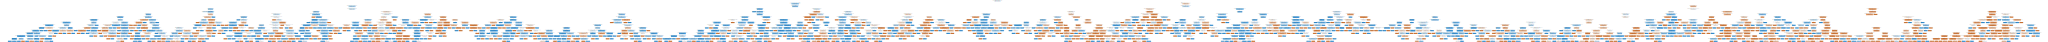

In [6]:
# visualizando uma das árvores
tree = rf.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=x_display,  
                            filled=True,  
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

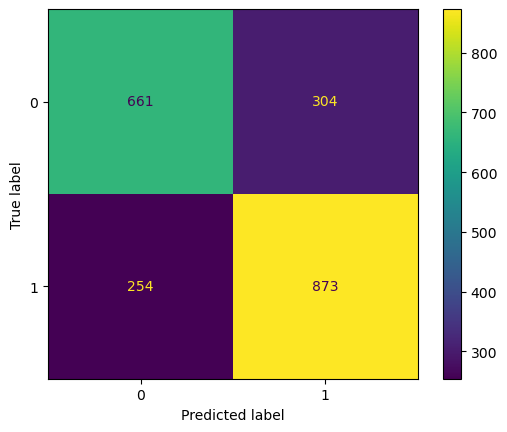

In [7]:
# matriz de confusão
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Aplicando SHAP

In [8]:
# código: https://www.kaggle.com/code/vikumsw/explaining-random-forest-model-with-shapely-values
import shap
shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


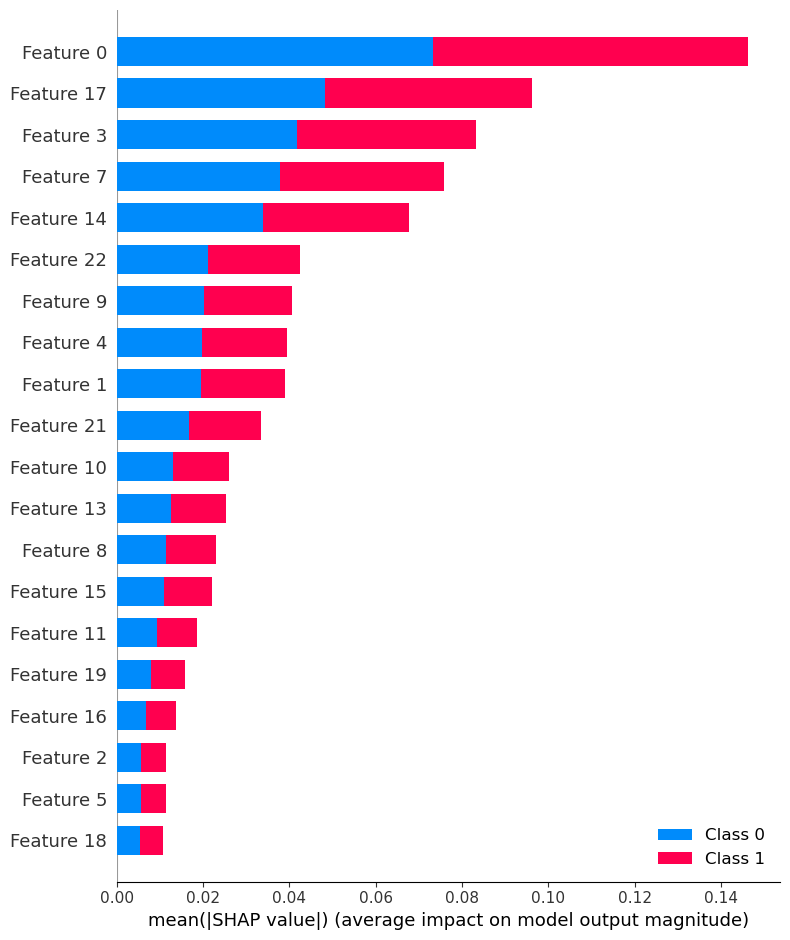

In [9]:
shap.summary_plot(shap_values, X)

# Aplicando LIME

In [11]:
# lime to explain random forests from oficial docs
# https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

import lime
import lime.lime_tabular

i = np.random.randint(0, X_test.shape[0])
selected_instance = X_test[i]

# instance lime will explain
print("selected instance label", y_test[i])
selected_instance

selected instance label 0


array([ 78, 197,   8,  93,  17,   1,   1,  94,  28,   6,   2,  18,   1,
        33,  22,   0,   0,   8,  -8,   1,   1,   0,  33], dtype=int64)

In [13]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=x_display.values.tolist(), class_names=['bad', 'good'])
exp = explainer.explain_instance(selected_instance, rf.predict_proba, num_features=len(X_test), top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)